# Imports

In [8]:
import numpy as np
import pandas as pd
import math

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.lines import Line2D

import pingouin as pg
from scipy import stats

import squarify as sq

import warnings
warnings.filterwarnings('ignore')

# Dataset Figure

In [2]:
labels = ['Interactions\n10,000,000', 'Students\n32,593', 'Resources\n6,364', 'Courses\n22', 'Stages/Course\n10']
values = [100, 28, 20, 5, 4]
real_vals = ['32,593', '22', '6.364', '10.000.000', '10']
parents = ['Used data for predictions', 'Courses', 'Used data for predictions', 'Used data for predictions', 'Courses', 'Used data for predictions']

Text(0.5, 1.0, 'Used data for predictions')

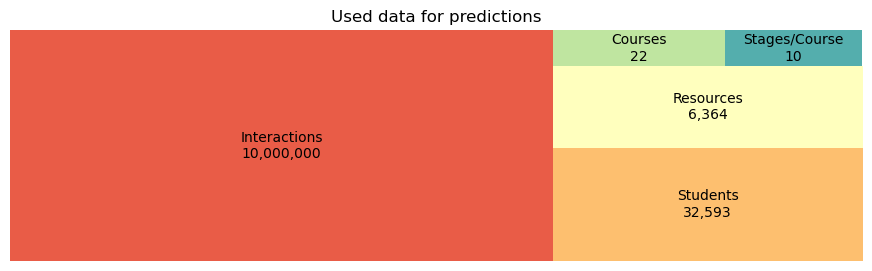

In [4]:
plt.figure(figsize=(11, 3))
sq.plot(sizes=values, label=labels, color=sns.color_palette("Spectral", len(labels)))
plt.axis('off')
plt.title('Used data for predictions', fontsize=12)
#plt.savefig('images/oula.eps', format='eps')

# Get data

In [9]:
# This piece of code is used to obtain the interactionsVle.csv file
o_studvle = pd.read_csv('./../../datasets/olau/studentVle.csv')
result = pd.DataFrame(columns=['code_module', 'code_presentation', 'id_site', 'id_student', 'date', 'sum_click'])
copy = o_studvle.copy()
for student in tqdm(copy['id_student'].unique()):
    stud_df = copy.copy()[copy['id_student'] == student]
    stud_df['date_d'] = stud_df['date'].shift()
    stud_df['id_site_d'] = stud_df['id_site'].shift()
    breaks = ((stud_df['date_d'] != stud_df['date']) | (stud_df['id_site_d'] != stud_df['id_site']))
    stud_df["sum_click_t"] = breaks.cumsum()
    stud_df.drop(['date_d', 'id_site_d'], axis=1, inplace=True)
    aux = stud_df.groupby(['code_module', 'code_presentation', 'id_site', 'id_student', 'date', 'sum_click_t'], sort=False).agg({'sum_click': 'sum'}).reset_index().drop(['sum_click_t'], axis=1)
    aux.set_index(stud_df[breaks.to_list()].index, inplace=True)
    result = pd.concat([result, aux])

100%|██████████| 26074/26074 [3:05:38<00:00,  2.34it/s]    


In [ ]:
o_stud = pd.read_csv('./data/studentInfo.csv')
intvle = pd.read_csv('./data/interactionsVle.csv', index_col=0)
vle = pd.read_csv('./data/vle.csv')

In [10]:
print(f"Unique vle activities: {len(vle['activity_type'].unique())}")
print(f"Unique vle resources: {len(vle['id_site'].unique())}")

Unique vle activities: 20
Unique vle resources: 6364


## Data by course

In [11]:
o_stud['course'] = o_stud['code_module'] + o_stud['code_presentation']
o_stud.drop(['code_module', 'code_presentation'], axis=1, inplace=True)

intvle['course'] = intvle['code_module'] + intvle['code_presentation']
intvle.drop(['code_module', 'code_presentation'], axis=1, inplace=True)

intvle.date = intvle.date.astype(int)
intvle.sort_values(['date', 'course'], inplace=True)

In [12]:
courses_dict = {}
result = pd.DataFrame()
for module in intvle['course'].unique():
    course = intvle[intvle['course'] == module].copy()
    pivoted = course.pivot_table(index='id_student', columns='id_site', values='sum_click', aggfunc='count', fill_value=0)
    result = pd.concat([result, pivoted], axis=1)
    pivoted = pd.merge(pivoted, o_stud[o_stud['course'] == module][['id_student', 'final_result']], on='id_student', how='outer')
    pivoted.fillna(0, inplace=True)
    if (pivoted.shape[0] != 0):
        courses_dict[module] = pivoted

In [13]:
res_count = []
for courses in courses_dict:
    res_count.append(courses_dict[courses].shape[1])

res_count = np.array(res_count)
print(f"Average number of resources per course: {res_count.mean()} with a standard deviation of {res_count.std()}")

Average number of resources per course: 286.90909090909093 with a standard deviation of 144.03910740771036


## Data by stage

In [23]:
max_date = intvle['date'].max()
min_date = intvle['date'].min()
stages = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
number_of_stages = 10
number_of_dates_per_stage = math.ceil((max_date - min_date) / number_of_stages)
intvle_stages = {}
for i in range(number_of_stages):
    intvle_stages[stages[i]] = intvle[(intvle['date'] >= min_date) & (intvle['date'] < min_date + (i + 1) * number_of_dates_per_stage)].copy()

In [24]:
courses_dict_stages = {}
result = pd.DataFrame()
for stage in stages:
    origin = intvle_stages[stage].copy()
    for comp_course in origin['course'].unique():
        course = origin[(origin['course'] == comp_course)].copy()
        pivoted = course.pivot_table(index='id_student', columns='id_site', values='sum_click', aggfunc='count', fill_value=0)
        result = pd.concat([result, pivoted], axis=1)
        pivoted = pd.merge(pivoted, o_stud[(o_stud['course'] == comp_course)][['id_student', 'final_result']], on='id_student', how='outer')
        pivoted.fillna(0, inplace=True)
        if (pivoted.shape[0] != 0):
            courses_dict_stages[comp_course + '_' + stage] = pivoted

In [81]:
for course, course_data in courses_dict_stages.items():
    course_data.to_csv(f'./course_stages_data/{course}.csv')

# Statistics

In [27]:
data = pd.DataFrame(columns=['id_site', 'id_student', 'date', 'sum_click', 'course', 'stage'])
for stage in intvle_stages:
    vle_a = intvle_stages[stage]
    vle_a['stage'] = stage
    data = pd.concat([data, vle_a], axis=0)

In [28]:
students = [560024, 199782, 2692101]
o_stud[(o_stud['id_student'].isin(students) & (o_stud['course'] == 'DDD2013B'))]

,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,course
13192,199782,M,Wales,Lower Than A Level,40-50%,0-35,0,60,N,Fail,DDD2013B
14161,560024,M,East Anglian Region,A Level or Equivalent,40-50%,0-35,0,60,N,Distinction,DDD2013B
14388,2692101,M,Wales,Lower Than A Level,40-50%,0-35,0,90,N,Withdrawn,DDD2013B


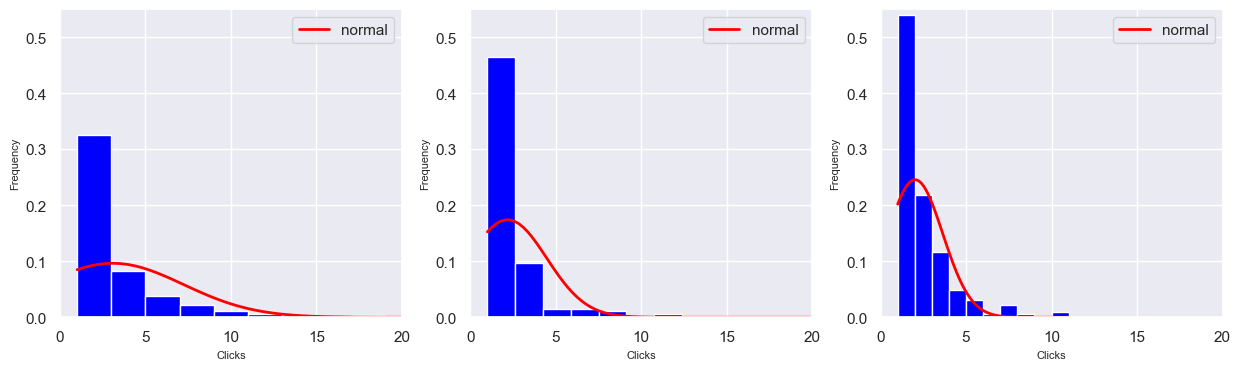

In [83]:
normals = []
data.sum_click = data.sum_click.astype(int)
data.id_student = data.id_student.astype(str)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
stage = '100'
course = 'DDD2013B'
for i, student in enumerate(['467413', '403085', '500006']):
    course_stage = data[((data.course == course) & (data.stage == stage) & (data.id_student == student))]['sum_click']
    stat, p_valor = stats.shapiro(course_stage)
    normals.append(p_valor < 0.05)
    # Valores de la media (mu) y desviación típica (sigma) de cada grupo
    mu, sigma = stats.norm.fit(course_stage)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(course_stage), max(course_stage), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico distribución
    axs[i].plot(x_hat, y_hat, linewidth=2, label='normal', color='red')
    axs[i].hist(x=course_stage, density=True, bins=len(course_stage.unique()), color="blue")
    axs[i].set_xlim(0, 20)
    axs[i].set_ylim(0, 0.55)
    axs[i].set_xlabel('Clicks', fontsize=8)
    axs[i].set_ylabel('Frequency', fontsize=8)
    axs[i].legend()
#plt.savefig(f'images/pass_students.eps', format='eps')

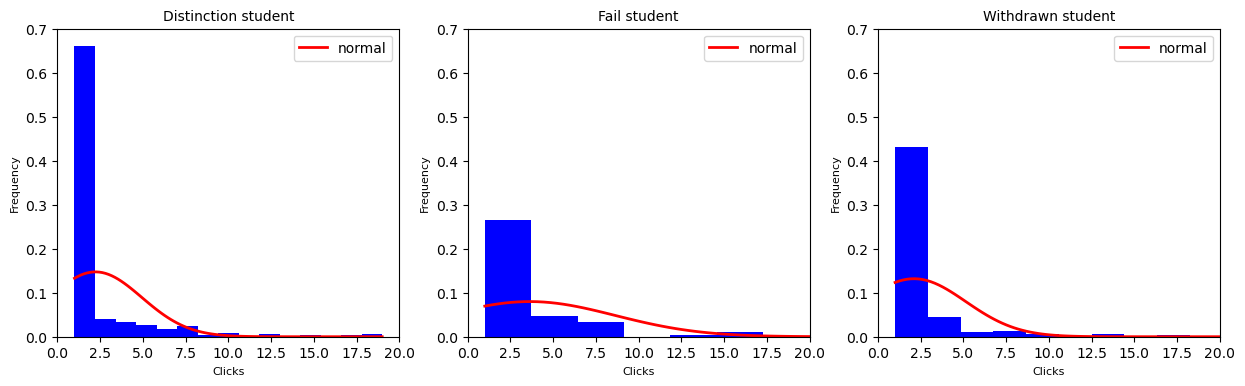

In [30]:
normals = []
data.sum_click = data.sum_click.astype(int)
data.id_student = data.id_student.astype(str)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
stage = '100'
course = 'DDD2013B'
results = ['Distinction', 'Fail', 'Withdrawn']
for i, student in enumerate(['560024', '199782', '2692101']):
    course_stage = data[((data.course == course) & (data.stage == stage) & (data.id_student == student))]['sum_click']
    stat, p_valor = stats.shapiro(course_stage)
    normals.append(p_valor < 0.05)
    # Valores de la media (mu) y desviación típica (sigma) de cada grupo
    mu, sigma = stats.norm.fit(course_stage)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(course_stage), max(course_stage), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico distribución
    axs[i].plot(x_hat, y_hat, linewidth=2, label='normal', color='red')
    axs[i].hist(x=course_stage, density=True, bins=len(course_stage.unique()), color="blue")
    axs[i].set_title(f"{results[i]} student", fontsize=10)
    axs[i].set_xlim(0, 20)
    axs[i].set_ylim(0, 0.7)
    axs[i].set_xlabel('Clicks', fontsize=8)
    axs[i].set_ylabel('Frequency', fontsize=8)
    axs[i].legend()
#plt.savefig(f'images/dist_students.eps', format='eps')

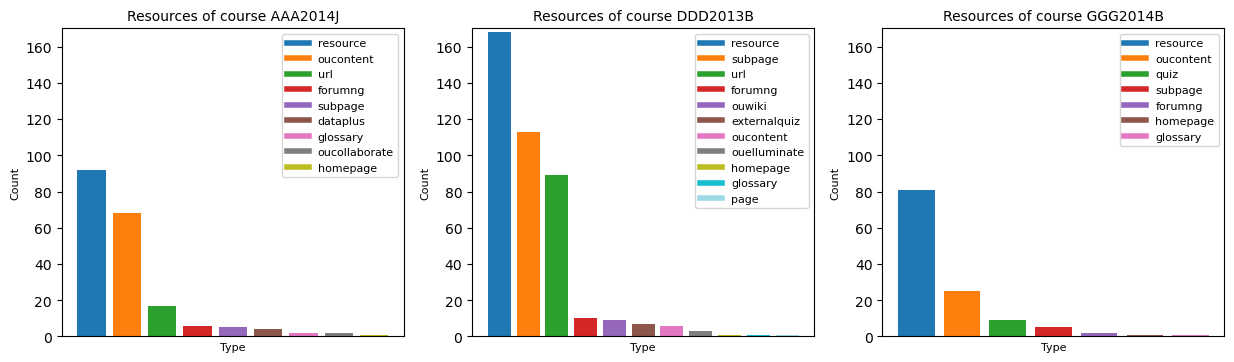

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Create an array with 11 colors of matplotlib
colors = plt.cm.tab20(np.linspace(0, 1, 11))
legend_lines = []
for color in colors:
    legend_lines.append(Line2D([0], [0], color=color, lw=4))

legends = [
    ['resource', 'oucontent', 'url', 'forumng', 'subpage', 'dataplus', 'glossary', 'oucollaborate', 'homepage'],
    ['resource', 'subpage', 'url', 'forumng', 'ouwiki', 'externalquiz', 'oucontent', 'ouelluminate', 'homepage', 'glossary', 'page'],
    ['resource', 'oucontent', 'quiz', 'subpage', 'forumng', 'homepage', 'glossary']
]

for i, course in enumerate(['AAA2014J', 'DDD2013B', 'GGG2014B']):
    resources = data[(data['course'] == course) & (data['stage'] == '100')].id_site.unique()
    axs[i].bar(vle[vle['id_site'].isin(resources)].activity_type.value_counts().index.to_list(), vle[vle['id_site'].isin(resources)].activity_type.value_counts().values, color=colors)
    #axs[i].tick_params(axis='x', labelrotation=45, labelsize=8, labelright=True)
    axs[i].set_xticks([])
    axs[i].set_ylim(0, 170)
    axs[i].set_title(f'Resources of course {course}', fontsize=10)
    axs[i].set_xlabel('Type', fontsize=8)
    axs[i].set_ylabel('Count', fontsize=8)
    axs[i].legend(legend_lines, legends[i], fontsize=8)
#plt.savefig(f'images/resource_dist.eps', format='eps')

In [33]:
data['course_stage'] = data['course'] + '_' + data['stage']
data.sum_click = data.sum_click.astype(int)

In [40]:
sum(pg.normality(data, dv='sum_click', group='stage')['normal']) ## 0 means all normal value are false

0

In [41]:
sum(pg.normality(data, dv='sum_click', group='course')['normal'])

0

In [42]:
sum(pg.normality(data, dv='sum_click', group='course_stage')['normal'])

0

In [43]:
pg.homoscedasticity(data=data, dv='sum_click', group='stage')

,W,pval,equal_var
levene,778.588003,0.0,False


In [44]:
pg.homoscedasticity(data=data, dv='sum_click', group='course')

,W,pval,equal_var
levene,15238.295427,0.0,False


In [45]:
pg.homoscedasticity(data=data, dv='sum_click', group='course_stage')

,W,pval,equal_var
levene,1547.211526,0.0,False


In [46]:
pg.kruskal(data=data, dv='sum_click', between='stage')

,Source,ddof1,H,p-unc
Kruskal,stage,9,11660.892582,0.0


In [47]:
pg.kruskal(data=data, dv='sum_click', between='course')

,Source,ddof1,H,p-unc
Kruskal,course,21,858317.77304,0.0


In [48]:
pg.kruskal(data=data, dv='sum_click', between='course_stage')

,Source,ddof1,H,p-unc
Kruskal,course_stage,219,883585.392513,0.0


In [ ]:
course_stages_count = len(data['course_stage'].unique())
for i in range(course_stages_count):
    for j in range(i + 1, course_stages_count):
        try:
            res = pg.mwu(data[data['course_stage'] == data['course_stage'].unique()[i]]['sum_click'], data[data['course_stage'] == data['course_stage'].unique()[j]]['sum_click'], alternative='two-sided')
            if (res['p-val'].values[0] > 0.05):
                print(f"Stage {data['course_stage'].unique()[i]} and stage {data['course_stage'].unique()[j]} are the same")
            else:
                print(f"Stage {data['course_stage'].unique()[i]} and stage {data['course_stage'].unique()[j]} are different")
        except:
            pass

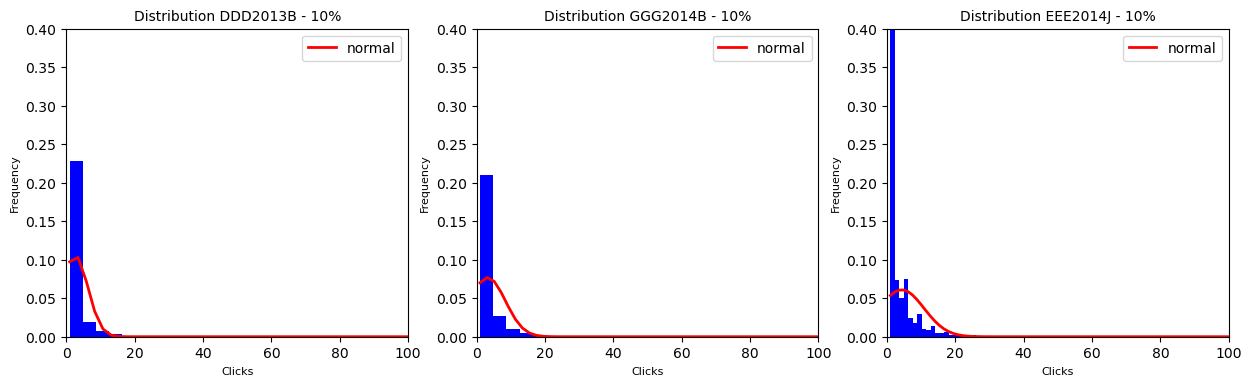

In [49]:
data.sum_click = data.sum_click.astype(int)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
stage = '10'
for i, course in enumerate(['DDD2013B', 'GGG2014B', 'EEE2014J']):
    course_stage = data[((data.course == course) & (data.stage == stage))]['sum_click']
    # Valores de la media (mu) y desviación típica (sigma) de cada grupo
    mu, sigma = stats.norm.fit(course_stage)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(course_stage), max(course_stage), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico distribución
    axs[i].plot(x_hat, y_hat, linewidth=2, label='normal', color='red')
    axs[i].hist(x=course_stage, density=True, bins=len(course_stage.unique()), color="blue")
    axs[i].set_title(f'Distribution {course} - {stage}%', fontsize=10)
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 0.40)
    axs[i].set_xlabel('Clicks', fontsize=8)
    axs[i].set_ylabel('Frequency', fontsize=8)
    axs[i].legend()
#plt.savefig(f'images/early_distributions.eps', format='eps')

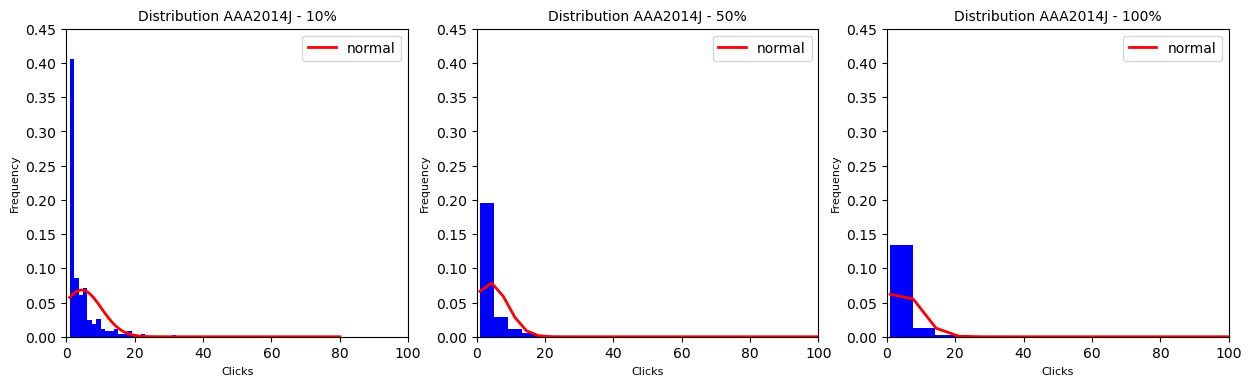

In [50]:
data.sum_click = data.sum_click.astype(int)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
course = 'AAA2014J'
for i, stage in enumerate(['10', '50', '100']):
    course_stage = data[((data.course == course) & (data.stage == stage))]['sum_click']
    # Valores de la media (mu) y desviación típica (sigma) de cada grupo
    mu, sigma = stats.norm.fit(course_stage)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(course_stage), max(course_stage), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico distribución
    axs[i].plot(x_hat, y_hat, linewidth=2, label='normal', color='red')
    axs[i].hist(x=course_stage, density=True, bins=len(course_stage.unique()), color="blue")
    axs[i].set_title(f'Distribution {course} - {stage}%', fontsize=10)
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 0.45)
    axs[i].set_xlabel('Clicks', fontsize=8)
    axs[i].set_ylabel('Frequency', fontsize=8)
    axs[i].legend()
#plt.savefig(f'images/{course}_distributions.eps', format='eps')

# Results

For executing the selectors, you have to run the scripts feature_selection.py and oe_feature_selection.py and remove the corresponding csv files to avoid problems with saving the results.

## Previous Results

In [55]:
prev_results = pd.read_csv('prev_results.csv')
prev_results.sort_values(by=['course', 'stage'], inplace=True)

## Voting Results

In [51]:
c_results = pd.read_csv('feature_selection.csv')
c_results.course = c_results.course.str.replace('course_stages_data/', '').str.replace('.csv', '')
c_results['module'] = c_results.course.str.split('_').str[0]
c_results['stage'] = c_results.course.str.split('_').str[1]
c_results['stage'] = c_results['stage'].astype(int)
c_results.sort_values(by=['module', 'stage'], inplace=True)
c_results.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='stage', ylabel='f1'>

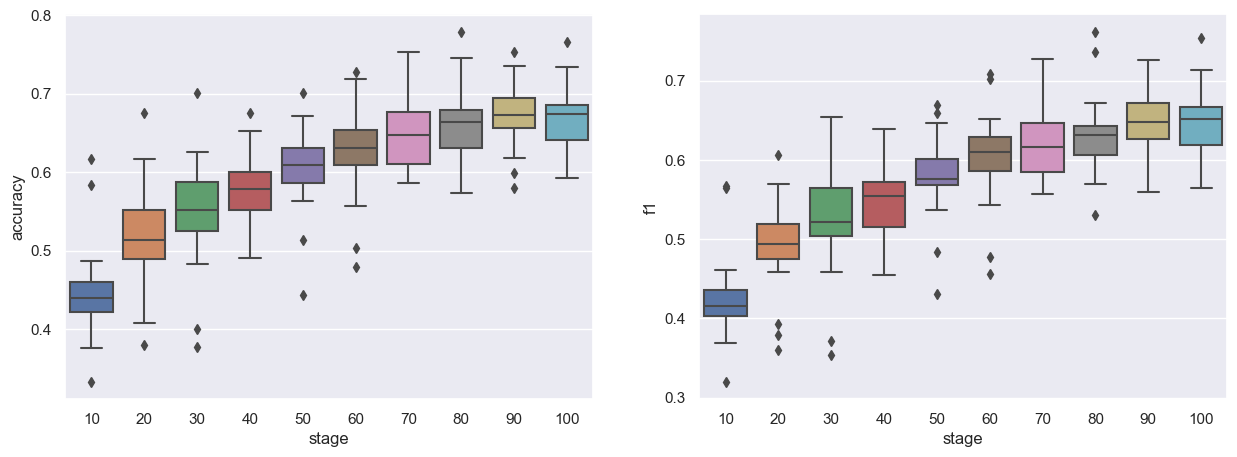

In [53]:
fig, ax = plt.subplots(1,2)
sns.set(rc={'figure.figsize': (15, 5)})
sns.boxplot(x='stage', y='accuracy', data=c_results, ax=ax[0])
sns.boxplot(x='stage', y='f1', data=c_results, ax=ax[1])
#plt.savefig('images/c_acc_f1.eps', format='eps')

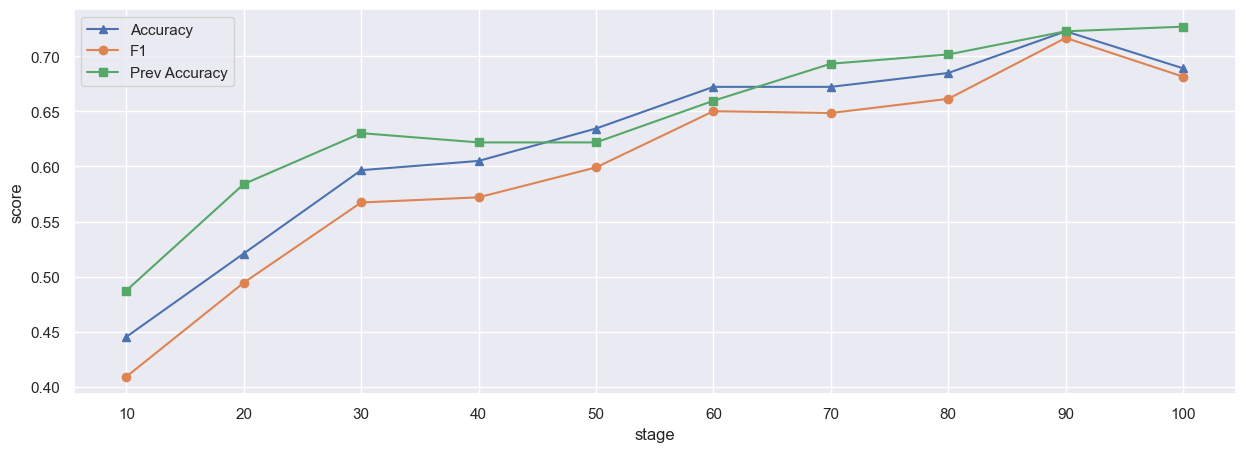

In [57]:
plt.plot(c_results[c_results.module == 'EEE2014J'].stage, c_results[c_results.module == 'EEE2014J'].accuracy, label='Accuracy', marker='^')
plt.plot(c_results[c_results.module == 'EEE2014J'].stage, c_results[c_results.module == 'EEE2014J'].f1, label='F1', marker='o')
prev_course_acc = prev_results[(prev_results.model == 'FOR') & (prev_results.course == 'EEE2014J')].accuracy
plt.plot(c_results[c_results.module == 'EEE2014J'].stage, prev_course_acc, label='Prev Accuracy', marker='s')
plt.xticks([i for i in range(10, 101, 10)])
plt.xlabel('stage')
plt.ylabel('score')
plt.legend()
#plt.savefig('images/c_eee14j.eps', format='eps')

In [58]:
features = c_results[c_results.module == 'EEE2014J'].features.str.replace(r'\s+', ' ').apply(eval)
features.index = c_results.loc[features.index].stage

In [59]:
types_r = vle.activity_type.unique().tolist()
counts_r = [0 for i in range(len(types_r))]
resources_stage_count = {}
for stage, stage_feat in zip(features.index, features):
    resources_count = dict(zip(types_r, counts_r))
    for feat in stage_feat:
        resources = courses_dict_stages['EEE2014J_' + str(stage)].drop(columns=['final_result', 'id_student']).columns
        if feat >= len(resources):
            resource = resources[-1]
        else:
            resource = resources[feat]
        type_r = vle[vle.id_site == resource].activity_type.iloc[0]
        resources_count[type_r] += 1
    resources_stage_count[stage] = resources_count

<Figure size 1000x1000 with 0 Axes>

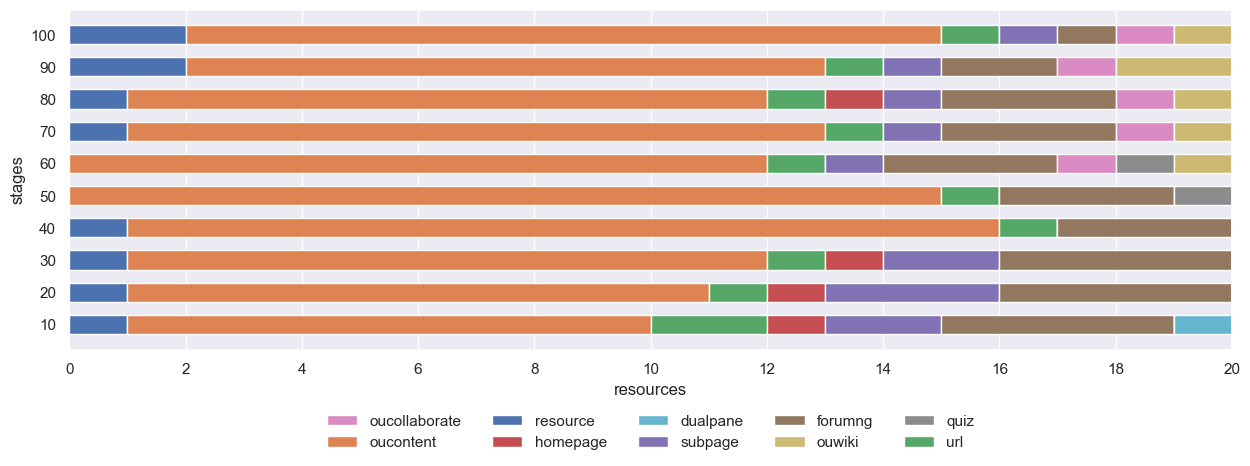

In [63]:
plt.figure(figsize=(10, 10))
prev_values = [0 for _ in range(len(resources_stage_count))]
fig, ax = plt.subplots()
types_res = []
for res_type in types_r:
    values = []
    exists_in_one = False
    for stage in resources_stage_count:
        count = resources_stage_count[stage][res_type]
        if count > 0:
            exists_in_one = True
            break
    if exists_in_one:
        types_res.append(res_type)
        for stage in resources_stage_count:
            count = resources_stage_count[stage][res_type]
            values.append(count)
        ax.barh(range(10, 101, 10), values, left=prev_values, label=res_type, height=6)
        prev_values = [sum(x) for x in zip(prev_values, values)]
    exists_in_one = False

# Add labels and title
plt.xlabel('resources')
plt.xticks([i for i in range(0, 21, 2)])
plt.ylabel('stages')
plt.yticks([i for i in range(10, 101, 10)])
plt.subplots_adjust(bottom=0.2)

handles, labels = ax.get_legend_handles_labels()
legend_elements = list(zip(labels, handles))
sorted_legend_elements = sorted(legend_elements, key=lambda x: -len(x[0]))
sorted_labels, sorted_handles = zip(*sorted_legend_elements)
leg = ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

# Display the plot
#plt.savefig('images/c_eee14j_feats.eps', format='eps', transparent=True)

In [61]:
types_r = vle.activity_type.unique().tolist()
counts_r = [0 for i in range(len(types_r))]
resources_count = dict(zip(types_r, counts_r))
for course in c_results.module.unique():
    features = c_results[c_results.module == 'EEE2014J'].features.str.replace(r'\s+', ' ').apply(eval)
    features.index = c_results.loc[features.index].stage
    
    for stage, stage_feat in zip(features.index, features):
        for feat in stage_feat:
            resources = courses_dict_stages['EEE2014J_' + str(stage)].drop(columns=['final_result', 'id_student']).columns
            if feat >= len(resources):
                resource = resources[-1]
            else:
                resource = resources[feat]
            type_r = vle[vle.id_site == resource].activity_type.iloc[0]
            resources_count[type_r] += 1

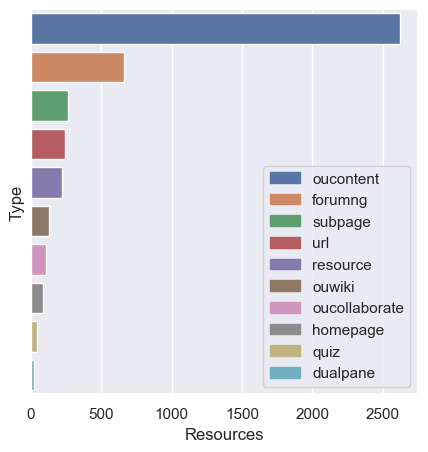

In [62]:
resources_count = {k: v for k, v in resources_count.items() if v != 0}

# sort the dictionary by value
sorted_resources_count = sorted(resources_count.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(5, 5))
sns.barplot(x=[x[1] for x in sorted_resources_count], y=[x[0] for x in sorted_resources_count])
plt.xlabel('Resources')
plt.yticks([])
plt.ylabel('Type')
# add a legend on the bottom left corner
colors = [bar.get_facecolor() for bar in plt.gca().patches]
labels = [x[0] for x in sorted_resources_count]
plt.legend(handles=[patches.Patch(color=colors[i], label="{:s}".format(labels[i])) for i in range(len(labels))], loc='lower right')
#plt.savefig('images/c_resources.eps', format='eps')

## Online Evolution Results

In [64]:
oe_results = pd.read_csv('oe_feature_selection.csv')
oe_results.course = oe_results.course.str.replace('course_stages_data/', '').str.replace('.csv', '')
oe_results['module'] = oe_results.course.str.split('_').str[0]
oe_results['stage'] = oe_results.course.str.split('_').str[1]
oe_results['stage'] = oe_results['stage'].astype(int)
oe_results.sort_values(by=['module', 'stage'], inplace=True)
oe_results.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='stage', ylabel='f1'>

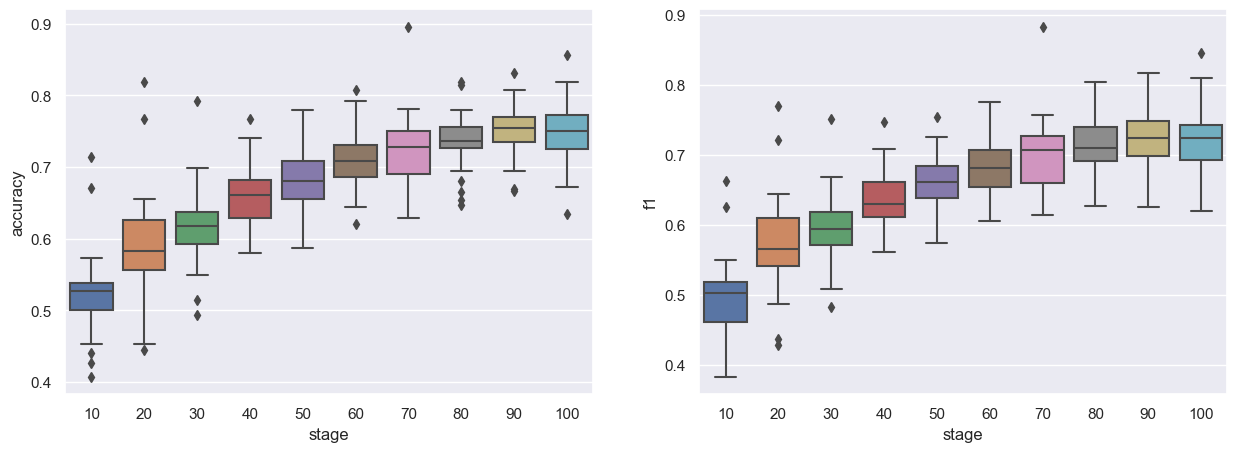

In [66]:
fig, ax = plt.subplots(1,2)
sns.set(rc={'figure.figsize': (15, 5)})
sns.boxplot(x='stage', y='accuracy', data=oe_results, ax=ax[0])
sns.boxplot(x='stage', y='f1', data=oe_results, ax=ax[1])
#plt.savefig('images/oe_acc_f1.eps', format='eps')

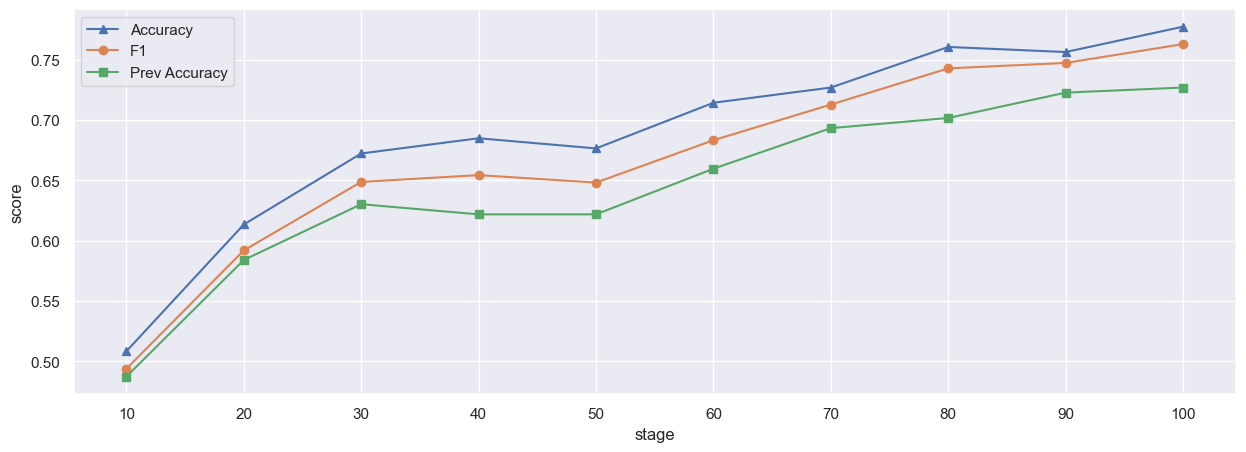

In [68]:
plt.plot(oe_results[oe_results.module == 'EEE2014J'].stage, oe_results[oe_results.module == 'EEE2014J'].accuracy, label='Accuracy', marker='^')
plt.plot(oe_results[oe_results.module == 'EEE2014J'].stage, oe_results[oe_results.module == 'EEE2014J'].f1, label='F1', marker='o')
prev_oe_acc = prev_results[(prev_results.model == 'FOR') & (prev_results.course == 'EEE2014J')].accuracy
plt.plot(oe_results[oe_results.module == 'EEE2014J'].stage, prev_oe_acc, label='Prev Accuracy', marker='s')
plt.xticks([i for i in range(10, 101, 10)])
plt.xlabel('stage')
plt.ylabel('score')
plt.legend()
#plt.savefig('images/oe_eee14j.eps', format='eps')

In [69]:
features = oe_results[oe_results.module == 'EEE2014J'].features.str.replace(r'\s+', ' ').apply(lambda x: x[:1] + x[2:]).str.replace(' ', ', ').apply(eval)
features.index = oe_results.loc[features.index].stage

In [70]:
types_r = vle.activity_type.unique().tolist()
counts_r = [0 for i in range(len(types_r))]
resources_stage_count = {}
for stage, stage_feat in zip(features.index, features):
    resources_count = dict(zip(types_r, counts_r))
    for feat in stage_feat:
        resources = courses_dict_stages['EEE2014J_' + str(stage)].drop(columns=['final_result', 'id_student']).columns
        if feat >= len(resources):
            resource = resources[-1]
        else:
            resource = resources[feat]
        type_r = vle[vle.id_site == resource].activity_type.iloc[0]
        resources_count[type_r] += 1
    resources_stage_count[stage] = resources_count

<Figure size 1000x1000 with 0 Axes>

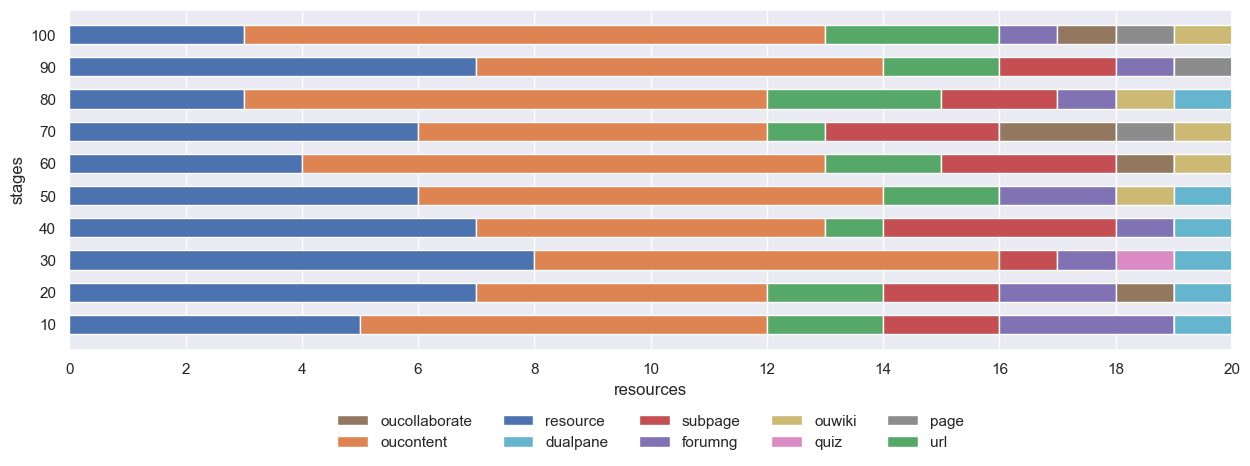

In [71]:
plt.figure(figsize=(10, 10))
prev_values = [0 for _ in range(len(resources_stage_count))]
fig, ax = plt.subplots()
types_res = []
for res_type in types_r:
    values = []
    exists_in_one = False
    for stage in resources_stage_count:
        count = resources_stage_count[stage][res_type]
        if count > 0:
            exists_in_one = True
            break
    if exists_in_one:
        types_res.append(res_type)
        for stage in resources_stage_count:
            count = resources_stage_count[stage][res_type]
            values.append(count)
        ax.barh(range(10, 101, 10), values, left=prev_values, label=res_type, height=6)
        prev_values = [sum(x) for x in zip(prev_values, values)]
    exists_in_one = False

# Add labels and title
plt.xlabel('resources')
plt.xticks([i for i in range(0, 21, 2)])
plt.ylabel('stages')
plt.yticks([i for i in range(10, 101, 10)])
plt.subplots_adjust(bottom=0.2)

handles, labels = ax.get_legend_handles_labels()
legend_elements = list(zip(labels, handles))
sorted_legend_elements = sorted(legend_elements, key=lambda x: -len(x[0]))
sorted_labels, sorted_handles = zip(*sorted_legend_elements)
leg = ax.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

# Display the plot
#plt.savefig('images/oe_eee14j_feats.eps', format='eps', transparent=True)

In [72]:
types_r = vle.activity_type.unique().tolist()
counts_r = [0 for i in range(len(types_r))]
resources_count = dict(zip(types_r, counts_r))
for course in oe_results.module.unique():
    features = oe_results[oe_results.module == course].features.str.replace(r'\s+', ' ').apply(lambda x: x[:1] + x[2:]).str.replace(' ', ', ').apply(eval)
    features.index = oe_results.loc[features.index].stage
    
    for stage, stage_feat in zip(features.index, features):
        for feat in stage_feat:
            resources = courses_dict_stages['EEE2014J_' + str(stage)].drop(columns=['final_result', 'id_student']).columns
            if feat >= len(resources):
                resource = resources[-1]
            else:
                resource = resources[feat]
            type_r = vle[vle.id_site == resource].activity_type.iloc[0]
            resources_count[type_r] += 1

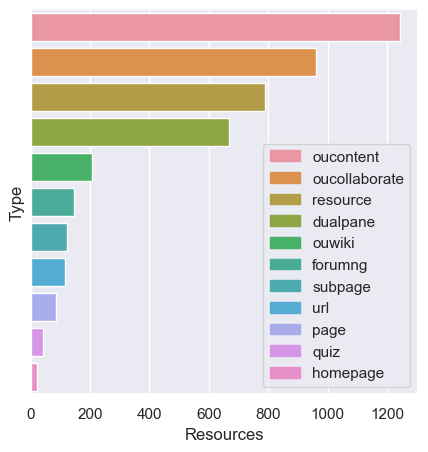

In [73]:
resources_count = {k: v for k, v in resources_count.items() if v != 0}

# sort the dictionary by value
sorted_resources_count = sorted(resources_count.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(5, 5))
sns.barplot(x=[x[1] for x in sorted_resources_count], y=[x[0] for x in sorted_resources_count])
plt.xlabel('Resources')
plt.yticks([])
plt.ylabel('Type')
# add a legend on the bottom left corner
colors = [bar.get_facecolor() for bar in plt.gca().patches]
labels = [x[0] for x in sorted_resources_count]
plt.legend(handles=[patches.Patch(color=colors[i], label="{:s}".format(labels[i])) for i in range(len(labels))], loc='lower right')
#plt.savefig('images/oe_resources.eps', format='eps')

# Results Comparison

In [74]:
# OE + previous
alpha = 0.05
for stage in stages:
    normal = True
    var = True
    oe_acc = oe_results[oe_results.stage == int(stage)].accuracy
    prev_acc = prev_results[(prev_results.model == 'FOR') & (prev_results.stage == int(stage))].accuracy
    _, p_oe = stats.shapiro(oe_acc)
    _, p_prev = stats.shapiro(prev_acc)
    if p_oe < alpha or p_prev < alpha:
        normal = False
    
    p_value_var = stats.levene(oe_acc, prev_acc)
    if p_value_var.pvalue < alpha:
        var = False

    if normal and var:
        _, p = stats.ttest_ind(oe_acc, prev_acc)
        print('TTest Stage: ' + str(stage) + ' p-value: ' + str(p))
    elif not normal and not var:
        _, p = stats.ttest_ind(oe_acc, prev_acc, equal_var=False)
        print('TTest Not Stage: ' + str(stage) + ' p-value: ' + str(p))
    else:
        _, p = stats.mannwhitneyu(oe_acc, prev_acc)
        print('Man Stage: ' + str(stage) + ' p-value: ' + str(p))
    print(f'OE acc: {oe_acc.mean()}, Previous acc: {prev_acc.mean()}')
    print(f"Diff: {oe_acc.mean() - prev_acc.mean()}")
    print('')

Man Stage: 10 p-value: 0.04730304682765163
OE acc: 0.524381174705775, Previous acc: 0.4946655935803818
Diff: 0.029715581125393242

TTest Stage: 20 p-value: 0.06244807097411642
OE acc: 0.5934186783924504, Previous acc: 0.5491226106503776
Diff: 0.04429606774207284

Man Stage: 30 p-value: 0.024984919235063748
OE acc: 0.6186504566523232, Previous acc: 0.5732397360309475
Diff: 0.045410720621375744

Man Stage: 40 p-value: 0.0019450568916334443
OE acc: 0.6574635877837607, Previous acc: 0.6059509488351916
Diff: 0.051512638948569056

Man Stage: 50 p-value: 0.00012408612271547353
OE acc: 0.6810126962370263, Previous acc: 0.6227532170012292
Diff: 0.05825947923579711

TTest Stage: 60 p-value: 0.00016005332456741928
OE acc: 0.7067261471368956, Previous acc: 0.6501183666085729
Diff: 0.056607780528322715

TTest Stage: 70 p-value: 0.0008477903579462121
OE acc: 0.7240210789522012, Previous acc: 0.6675363669638985
Diff: 0.05648471198830274

TTest Stage: 80 p-value: 0.00045884480132031384
OE acc: 0.73378

In [75]:
# C + previous
alpha = 0.05
for stage in stages:
    normal = True
    var = True
    c_acc = c_results[c_results.stage == int(stage)].accuracy
    prev_acc = prev_results[(prev_results.model == 'FOR') & (prev_results.stage == int(stage))].accuracy
    _, p_oe = stats.shapiro(c_acc)
    _, p_prev = stats.shapiro(prev_acc)
    if p_oe < alpha or p_prev < alpha:
        normal = False
    
    p_value_var = stats.levene(c_acc, prev_acc)
    if p_value_var.pvalue < alpha:
        var = False

    if normal and var:
        _, p = stats.ttest_ind(c_acc, prev_acc)
        print('TTest Stage: ' + str(stage) + ' p-value: ' + str(p))
    elif not normal and not var:
        _, p = stats.ttest_ind(c_acc, prev_acc, equal_var=False)
        print('TTest Not Stage: ' + str(stage) + ' p-value: ' + str(p))
    else:
        _, p = stats.mannwhitneyu(c_acc, prev_acc)
        print('Man Stage: ' + str(stage) + ' p-value: ' + str(p))
    print(f'OE acc: {c_acc.mean()}, Previous acc: {prev_acc.mean()}')
    print(f"Diff: {c_acc.mean() - prev_acc.mean()}")
    print('')

Man Stage: 10 p-value: 0.002559369440611284
OE acc: 0.44834382505023024, Previous acc: 0.4946655935803818
Diff: -0.046321768530151575

TTest Stage: 20 p-value: 0.12500710926837502
OE acc: 0.5176603647687102, Previous acc: 0.5491226106503776
Diff: -0.03146224588166735

Man Stage: 30 p-value: 0.058800824731146194
OE acc: 0.5471715242427587, Previous acc: 0.5732397360309475
Diff: -0.026068211788188744

Man Stage: 40 p-value: 0.005815022136183173
OE acc: 0.5752968158477539, Previous acc: 0.6059509488351916
Diff: -0.030654132987437688

Man Stage: 50 p-value: 0.14233728325212797
OE acc: 0.6032967751708299, Previous acc: 0.6227532170012292
Diff: -0.019456441830399296

TTest Stage: 60 p-value: 0.1260034022835082
OE acc: 0.6258801686432017, Previous acc: 0.6501183666085729
Diff: -0.02423819796537119

TTest Stage: 70 p-value: 0.13049688357253128
OE acc: 0.6465661109615154, Previous acc: 0.6675363669638985
Diff: -0.020970256002383114

TTest Stage: 80 p-value: 0.08822453113529903
OE acc: 0.6584926

In [76]:
# OE + C
alpha = 0.05
for stage in stages:
    normal = True
    var = True
    oe_acc = oe_results[oe_results.stage == int(stage)].accuracy
    c_acc = c_results[c_results.stage == int(stage)].accuracy
    _, p_oe = stats.shapiro(oe_acc)
    _, p_c = stats.shapiro(c_acc)
    if p_oe < alpha or p_c < alpha:
        normal = False
    
    p_value_var = stats.levene(oe_acc, c_acc)
    if p_value_var.pvalue < alpha:
        var = False

    if normal and var:
        _, p = stats.ttest_ind(oe_acc, c_acc)
        print('TTest Stage: ' + str(stage) + ' p-value: ' + str(p))
    elif not normal and not var:
        _, p = stats.ttest_ind(oe_acc, c_acc, equal_var=False)
        print('TTest Not Stage: ' + str(stage) + ' p-value: ' + str(p))
    else:
        _, p = stats.mannwhitneyu(oe_acc, c_acc)
        print('Man Stage: ' + str(stage) + ' p-value: ' + str(p))
    print(f'OE acc: {oe_acc.mean()}, Previous acc: {c_acc.mean()}')
    print(f"Diff: {oe_acc.mean() - c_acc.mean()}")
    print('')

Man Stage: 10 p-value: 0.0002622470511729809
OE acc: 0.524381174705775, Previous acc: 0.44834382505023024
Diff: 0.07603734965554482

TTest Stage: 20 p-value: 0.002124199120150944
OE acc: 0.5934186783924504, Previous acc: 0.5176603647687102
Diff: 0.07575831362374019

TTest Stage: 30 p-value: 0.0008919167783283956
OE acc: 0.6186504566523232, Previous acc: 0.5471715242427587
Diff: 0.07147893240956449

TTest Stage: 40 p-value: 3.2589515812498854e-07
OE acc: 0.6574635877837607, Previous acc: 0.5752968158477539
Diff: 0.08216677193600674

Man Stage: 50 p-value: 7.760282044738081e-06
OE acc: 0.6810126962370263, Previous acc: 0.6032967751708299
Diff: 0.0777159210661964

TTest Stage: 60 p-value: 6.250277902700304e-06
OE acc: 0.7067261471368956, Previous acc: 0.6258801686432017
Diff: 0.0808459784936939

TTest Stage: 70 p-value: 7.126099232990101e-06
OE acc: 0.7240210789522012, Previous acc: 0.6465661109615154
Diff: 0.07745496799068585

TTest Stage: 80 p-value: 2.8245537432456006e-06
OE acc: 0.733

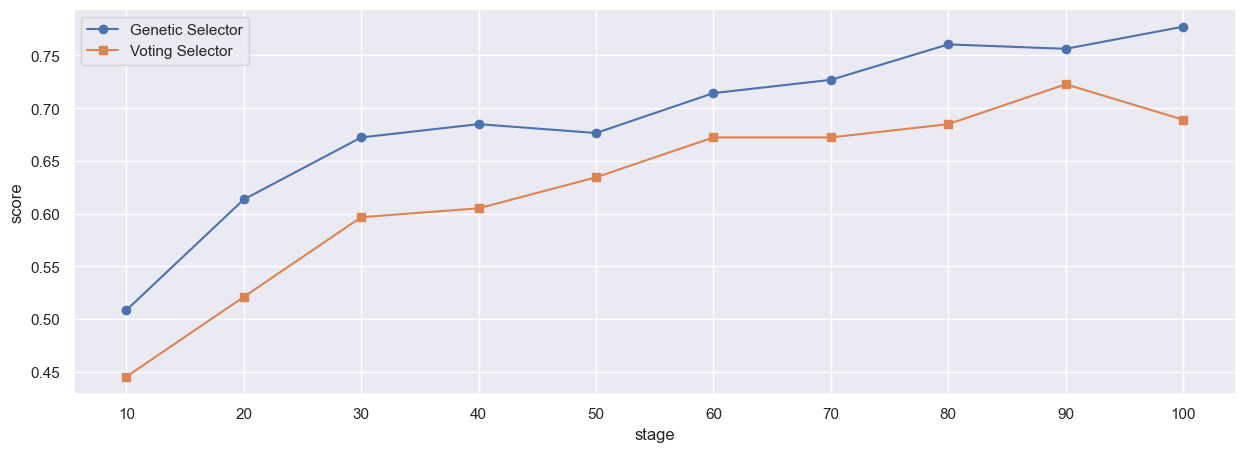

In [78]:
plt.plot(oe_results[oe_results.module == 'EEE2014J'].stage, oe_results[oe_results.module == 'EEE2014J'].accuracy, label='Genetic Selector', marker='o')
plt.plot(c_results[oe_results.module == 'EEE2014J'].stage, c_results[oe_results.module == 'EEE2014J'].accuracy, label='Voting Selector', marker='s')
plt.xticks([i for i in range(10, 101, 10)])
plt.xlabel('stage')
plt.ylabel('score')
plt.legend()
#plt.savefig('images/oe_c_eee14j.eps', format='eps')